<ipython-input-21-ea76618018d1>:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


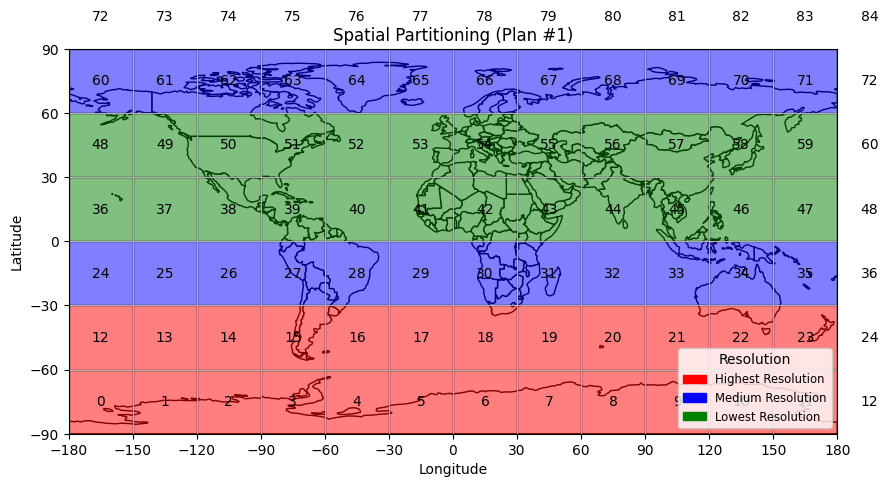

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define the grid size (in degrees)
grid_size = 30

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Load the basemap image (you need to import geopandas for this)
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')

# Define colors for each row
colors = ['red', 'blue', 'green', 'green', 'blue', 'red']

# Plot the grids
num_rows = len(colors)
for i, lat in enumerate(range(-90, 91, grid_size)):
    color = colors[i-1]
    for j, lng in enumerate(range(-180, 181, grid_size)):
        rect = Rectangle((lng, lat), grid_size, grid_size, linewidth=1, edgecolor='black', facecolor=color, alpha=0.5)
        ax.add_patch(rect)
        # Add grid number
        ax.text(lng + grid_size / 2, lat + grid_size / 2, str(i * (361 // grid_size) + j), ha='center', va='center')

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Partitioning (Plan #1)")
plt.grid(True)
ax.set_xticks(range(-180, 181, grid_size))
ax.set_yticks(range(-90, 91, grid_size))

# Remove white space and make the map outline match the x and y axes
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Create a legend-like color indicator
legend_patches = [Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = ['Highest Resolution', 'Medium Resolution', 'Lowest Resolution']
ax.legend(legend_patches, legend_labels, loc='lower right', title='Resolution', fontsize='small')

plt.show()


In [20]:
import xml.etree.ElementTree as ET

def calculate_storage_per_partition(partition, partition_range, spatial_resolution, time_resolution):
    partition_start = int(partition.find('partitionStart').text)
    partition_end = int(partition.find('partitionEnd').text)
    num_subpartitions = (partition_end - partition_start + 1)
    # Calculate table size for one subpartition
    latitude_points = int(partition_range / spatial_resolution) + 1
    longitude_points = int(partition_range / spatial_resolution) + 1
    table_size = latitude_points * longitude_points * 2 #number_points*2bytes
    # Calculate the number of data points for each time resolution
    if time_resolution == "hour":
        time_units = 24 * time_range * 356
    elif time_resolution == "day":
        time_units = 356.25 * time_range * 3
    elif time_resolution == "month":
        time_units = 12 * time_range * 3   # Average days in a month
    elif time_resolution == "year":
        time_units = time_range * 3
    file_size = time_units * num_subpartitions*table_size
    # Calculate the storage required for one variable (assuming 4 bytes per data point)
    storage_per_variable = file_size / (1024 ** 3)  # Convert bytes to GB
    return storage_per_variable

# Parse the XML file
tree = ET.parse('data.xml')
root = tree.getroot()

variables = len(root.find('Variables'))
total_storage = 0
partition_range = int(root.find('PartitionRange').text)
time_range = int(root.find('TimeRange').find('range').text)

# Iterate over partitions and calculate storage required
partitions = root.find('Partitions').findall('partition')

for partition in partitions:
    spatial_resolution = float(partition.find('SpatialResolution').text)
    time_resolution =partition.find('TimeResolution').text.replace(" ", "")
    storage_per_partition = calculate_storage_per_partition(partition, partition_range, spatial_resolution, time_resolution)
    total_storage += storage_per_partition * variables

print("Total Storage Required:", round(total_storage, 3), "GB")


hour
12
121
121
30022248960
day
12
61
61
954436500.0
month
24
31
31
16606080
day
12
61
61
954436500.0
hour
12
121
121
30022248960
Total Storage Required: 57.714 GB
